In [2]:
import numpy as np
import time
import math
import gdal, gdalconst
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
# Selenographic latitude (delka)
lat = 31.4
# Longtitude (sirka)
lon = 21.2
# Colongitudo
col = 350

In [4]:
sun_angle = 360-col+90.0
eterm = 360-col
wterm = 360-col+180
img_x = (math.sin(math.radians(lon)))/2+0.5
img_y = (math.sin(math.radians(lat)))/2+0.5

print("Východní terminátor", eterm, "deg")
print("Západní terminárot", wterm, "deg")
print("Slnce je normalove na lat={}deg".format(sun_angle))
print("img x", img_x)
print("img y", img_y)

Východní terminátor 10 deg
Západní terminárot 190 deg
Slnce je normalove na lat=100.0deg
img x 0.6808122850410462
img y 0.7605048159202882


``` Prevodniky souradnic zrejme jsou spatne z duvodu nelinearni projekce```

### imCoordinates(ran, pos, ranx, rany)
 * ran - pole s rozlisenib obrazku
 * pos - souradnice v obrazku
 * ranx - rozsah souradnic obrazku v ose x (sirka)
 * rany - rozsah souradnic obrazku v ose y (delka)
#### Return
 * selenografické souradnice pixelu

In [5]:
def imGetCoord(pos):
    ran = imrange
    ranx=(-180,180)
    rany=(-90,90)
    
    if pos[0] < 0 or pos[0] > 990000:
        print("Position X (longtitude) is out of range <0, ...>")
        return -1
    if pos[1] < 0 or pos[1] > 990000:
        print("Position Y (latitude) is out of range <0, ...>")
        return -1
    
    rx = ranx[0]+pos[0]/ran[0]*(ranx[1]-ranx[0])
    ry = rany[0]+pos[1]/ran[1]*(rany[1]-rany[0])
    return (rx, -ry)

In [6]:
print(imrange)
imGetCoord([92160/10, 0])

NameError: name 'imrange' is not defined

### imGetPx
* ran - pole s rozlisenim obrazku
* pos - souradnice obrazku
* ranx- rozsah souradnic v ose x
* rany- rozsah souradnic v ose y
#### Return
* Poloha souradnic v obrazku

In [7]:
def imGetPx(pos):
    ranx=(-180,180)
    rany=(-90,90)
    ran = imrange
    
    if pos[0] < -180 or pos[0] > 180:
        print("Position X (longtitude) is out of range <-180, 180>")
        return -1
    if pos[1] < -90 or pos[1] > 90:
        print("Position Y (latitude) is out of range <-90, 90>")
        return -1
    
    px = ran[0]*(pos[0]+180.0)/360.0
    py = ran[1]*(pos[1]+90.0)/180.0
    
    return (int(px), int(ran[1]-py))

In [8]:
print(imrange)
imGetPx([0, 90])

NameError: name 'imrange' is not defined

In [9]:
def getAltitude(value, scaling = 0.5):
    return (value * scaling) + 1737400 

### getAltitudeInDistance(value)
* altitude - vyska v danem bode
* distance - vzdalenost v pixelech od hledaneho mista v ose y
* sun_angle - uhel od vybraneho bodu ke smeru slunci
* rangey - velikost obrazku v ose y

$$ \frac {Altitude * sin(sun)}{\sin(180-sun-distance)} $$

In [10]:
def getAltitudeInDistance(altitude, distance, sun_angle):
   ad= 360*(distance/imrange[0])
   newAlt = altitude*math.sin(math.radians(sun_angle))
   newAlt = newAlt/math.sin(math.radians(180-sun_angle-ad))
   return newAlt

In [11]:
# imcoordinates test
getAltitudeInDistance(1737400)

TypeError: getAltitudeInDistance() missing 2 required positional arguments: 'distance' and 'sun_angle'

In [12]:
# https://www.gis.usu.edu/~chrisg/python/2009/lectures/ospy_slides4.pdf

#simple cylindrical projection: http://mathworld.wolfram.com/CylindricalProjection.html

In [30]:
s = gdal.Open('../data/LRO/Lunar_LRO_LOLA_Global_LDEM_118m_Mar2014.tif', gdalconst.GA_ReadOnly)  # topography
a = gdal.Open('../data/LRO/Lunar_Clementine_UVVIS_750nm_Global_Mosaic_118m_v2.1.tif', gdalconst.GA_ReadOnly) # albedo

In [44]:
print("Topography", s.RasterCount, "X:",s.RasterXSize, "Y:", s.RasterYSize)
imrange = (s.RasterXSize, s.RasterYSize)
print("Albedo  ", a.RasterCount, "X:",a.RasterXSize, "Y:", a.RasterYSize)
alrange = (a.RasterXSize, a.RasterYSize)

Topography 1 X: 92160 Y: 46080
Albedo   1 X: 92160 Y: 46080


In [31]:
def getNormal(a, x, y):
    return normalize(np.array([-2*(a[y,x-1]-a[y,x+1]), -2*(a[y-1,x]-a[y+1,x]), 4]))
    

In [32]:
def normalize(vec):
    return vec/np.linalg.norm(vec)

In [90]:
#Delka, Sirka
center = [15.8, 16.2]
size = [1, 2]

calc_x1, calc_y1 = imGetPx([center[0]-size[0]/2, center[1]+size[1]/2])
calc_x2, calc_y2 = imGetPx([center[0]+size[0]/2, center[1]-size[1]/2])

distance = 500

print(imrange)
print(calc_x1/imrange[0], calc_y1/imrange[1])
print("Scanovany prostor bude X: {}:{} az po Y: {}:{}".format(calc_x1, calc_x2, calc_y1, calc_y2))
print("To bude {} iterací".format((calc_x2-calc_x1)*(calc_y2-calc_y1)))

(92160, 46080)
0.5424913194444444 0.4044270833333333
Scanovany prostor bude X: 49996:50252 az po Y: 18636:19148
To bude 131072 iterací


(512, 757)
[[ 1.   0.5  0.5 ...  0.   1.   2. ]
 [ 1.   1.   1.  ...  1.   1.5  2. ]
 [ 1.   1.5  2.  ...  1.5  1.5  2. ]
 ...
 [ 3.   2.5  2.5 ... -0.5  0.5  1. ]
 [ 2.   2.5  2.5 ...  2.   2.   2. ]
 [ 3.   2.5  2.  ...  3.5  3.   3. ]]
(512, 257)


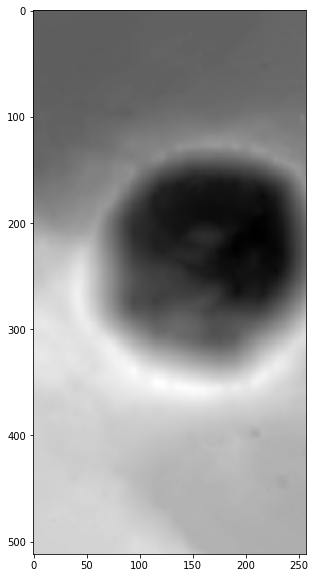

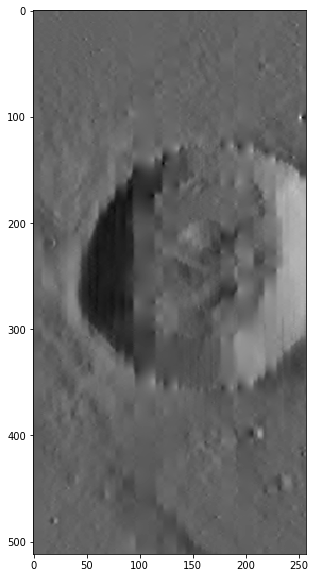

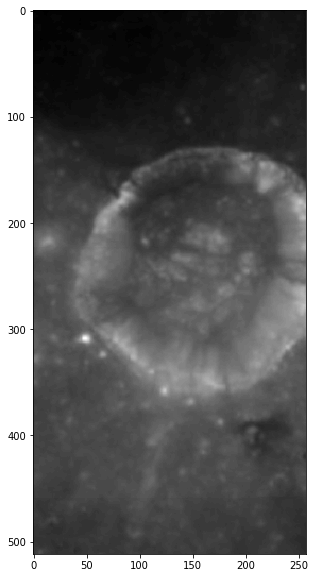

In [91]:
crop = s.ReadAsArray(calc_x1, calc_y1, abs(calc_x1-calc_x2)+distance+1, abs(calc_y1-calc_y2))
acrop = a.ReadAsArray(calc_x1, calc_y1, abs(calc_x1-calc_x2)+1, abs(calc_y1-calc_y2))
grad = np.array(np.gradient(crop[:, :-distance]))[1]

print(crop.shape)
print(grad)
print(grad.shape)

plt.imshow(crop[:, :-distance], cmap='gray')
plt.show()
plt.imshow(grad, cmap='gray')
plt.show()
plt.imshow(acrop, cmap='gray')
plt.show()

In [92]:
#shadow = np.zeros((abs(calc_y1-calc_y2), (abs(calc_x1-calc_x2))))
shadow = np.zeros(acrop.shape)
#shadow = acrop.copy()
#print(crop.shape)

local_sun = 180 - abs(imGetCoord((calc_x1, 0))[0] - sun_angle)
print("LocalSun", local_sun)

t_start = time.time()

# prochazej po sloupcich
for ax, x in enumerate(range(int(calc_x1)+1, int(calc_x2))):
    local_sun = 180 - abs(imGetCoord((x, 0))[0] - sun_angle)
    #local_sun_vector = normalize(np.array([1, 0, math.sin(math.radians(local_sun-90))/1]))
    done = ax/abs(calc_x1-calc_x2)+0.0000001
    rest = ((time.time()-t_start/(100*done))*(100-done*100))/60
    print("Sloupec {0:.2f}. done {1:.1f}, time:{2:0.1f}, rest:{3:.3f}".format(local_sun, done*100, time.time()-t_start, rest))
    
    # Prochazej radek po radku
    for ay, y in enumerate(range(int(calc_y1)+1, int(calc_y2)-1)):
        #print(x, y, a[ax,ay])
        local_height = getAltitude(crop[ay, ax])
        local_norm = getNormal(crop, ax, ay)
        #angle = np.math.atan2(np.linalg.det([local_norm,local_sun_vector]),np.dot(local_norm, local_sun_vector))
        
        #print(ax, ay, "vector",norm, local_sun_vector)
        
        for dist in range(1, distance):
            #cx = ax+dist
            cheight = getAltitude(crop[ay, ax+dist])
            rheight = getAltitudeInDistance(local_height, dist, local_sun)
            
            if cheight+5 > rheight:
                shadow[ay, ax] = abs(rheight-cheight)
                break

total_time = t_start-time.time()
print("Pocitani trvalo [min]", total_time/60)

LocalSun 95.29687499999997
Sloupec 95.30. done 0.0, time:0.0, rest:-257160714199649.531
Sloupec 95.30. done 0.4, time:0.9, rest:-3995908496.324
Sloupec 95.31. done 0.8, time:1.7, rest:-714389946.070
Sloupec 95.31. done 1.2, time:2.6, rest:372771335.521
Sloupec 95.32. done 1.6, time:3.4, rest:911332767.109
Sloupec 95.32. done 2.0, time:4.3, rest:1230452573.374
Sloupec 95.32. done 2.3, time:5.1, rest:1439851098.808
Sloupec 95.33. done 2.7, time:5.9, rest:1586551577.492
Sloupec 95.33. done 3.1, time:6.6, rest:1694065701.702
Sloupec 95.34. done 3.5, time:7.4, rest:1775455552.481
Sloupec 95.34. done 3.9, time:8.2, rest:1838558391.777
Sloupec 95.34. done 4.3, time:9.0, rest:1888361574.747
Sloupec 95.35. done 4.7, time:9.7, rest:1928190008.396
Sloupec 95.35. done 5.1, time:10.5, rest:1960345553.420
Sloupec 95.36. done 5.5, time:11.3, rest:1986472397.193
Sloupec 95.36. done 5.9, time:12.1, rest:2007776277.931
Sloupec 95.36. done 6.3, time:12.9, rest:2025161499.802
Sloupec 95.37. done 6.6, time

Sloupec 95.86. done 56.3, time:109.1, rest:1105087727.665
Sloupec 95.87. done 56.6, time:109.8, rest:1095357581.458
Sloupec 95.87. done 57.0, time:110.4, rest:1085623116.122
Sloupec 95.88. done 57.4, time:111.0, rest:1075884419.790
Sloupec 95.88. done 57.8, time:111.7, rest:1066141578.253
Sloupec 95.88. done 58.2, time:112.3, rest:1056394674.953
Sloupec 95.89. done 58.6, time:112.9, rest:1046643791.125
Sloupec 95.89. done 59.0, time:113.6, rest:1036889005.855
Sloupec 95.89. done 59.4, time:114.2, rest:1027130396.128
Sloupec 95.90. done 59.8, time:114.8, rest:1017368036.942
Sloupec 95.90. done 60.2, time:115.4, rest:1007602001.346
Sloupec 95.91. done 60.5, time:116.0, rest:997832360.496
Sloupec 95.91. done 60.9, time:116.6, rest:988059183.728
Sloupec 95.91. done 61.3, time:117.1, rest:978282538.586
Sloupec 95.92. done 61.7, time:117.7, rest:968502490.938
Sloupec 95.92. done 62.1, time:118.3, rest:958719104.987
Sloupec 95.93. done 62.5, time:118.9, rest:948932443.319
Sloupec 95.93. done 

In [59]:
mirroring = np.ones(acrop.shape)

local_sun = 180 - abs(imGetCoord((calc_x1, 0))[0] - sun_angle)
print("LocalSun", local_sun)

t_start = time.time()

# prochazej po sloupcich
for ax, x in enumerate(range(int(calc_x1)+1, int(calc_x2))):
    local_sun = 180 - abs(imGetCoord((x, 0))[0] - sun_angle)
    #local_sun_vector = normalize(np.array([1, 0, math.sin(math.radians(local_sun-90))/1]))
    
    done = ax/abs(calc_x1-calc_x2)+0.0000001
    rest = ((time.time()-t_start/(100*done))*(100-done*100))/60
    print("Sloupec {0:.2f}. done {1:.1f}, time:{2:0.1f}, rest:{3:.3f}".format(local_sun, done*100, time.time()-t_start, rest))
    
    # Prochazej radek po radku
    for ay, y in enumerate(range(int(calc_y1)+1, int(calc_y2)-1)):
        
        if shadow[ay, ax] == 0:
            print()
        
        #print(x, y, a[ax,ay])
        local_height = getAltitude(crop[ay, ax])
        local_norm = getNormal(crop, ax, ay)
        #angle = np.math.atan2(np.linalg.det([local_norm,local_sun_vector]),np.dot(local_norm, local_sun_vector))
        
        #print(ax, ay, "vector",norm, local_sun_vector)
        
    
    
total_time = t_start-time.time()
print("Pocitani trvalo [min]", total_time/60)

LocalSun 93.0
Sloupec 93.00. done 0.0, time:0.0, rest:-257160056733886.812
























































Sloupec 93.01. done 0.4, time:0.0, rest:-3995898281.700
































































Sloupec 93.01. done 0.8, time:0.0, rest:-714388122.490


































































Sloupec 93.02. done 1.2, time:0.0, rest:372770378.279






































































Sloupec 93.02. done 1.6, time:0.0, rest:911330431.611











































































Sloupec 93.02. done 2.0, time:0.1, rest:1230449420.688












































































Sloupec 93.03. done 2.3, time:0.1, rest:1439847409.497


















































































Sloupec 93.03. done 2.7, time:0.1, rest:1586547511.902
























































































Sloupec 93.26. done 25.4, time:0.8, rest:1843108016.310













































































































Sloupec 93.26. done 25.8, time:0.8, rest:1834597182.620









































































































Sloupec 93.27. done 26.2, time:0.8, rest:1826040540.504


































































































Sloupec 93.27. done 26.6, time:0.8, rest:1817440110.941



























































































Sloupec 93.27. done 27.0, time:0.9, rest:1808797797.722























































































Sloupec 93.28. done 27.3, time:0.9, rest:1800115395.862

































































































Sloupec 93.28. done 27.7, time:0.9, rest:17









































Sloupec 93.48. done 47.7, time:1.4, rest:1317839788.684
































































































































Sloupec 93.48. done 48.0, time:1.4, rest:1308233087.770


































































































































Sloupec 93.49. done 48.4, time:1.4, rest:1298619310.806











































































































































Sloupec 93.49. done 48.8, time:1.4, rest:1288998627.616
















































































































































Sloupec 93.50. done 49.2, time:1.5, rest:1279371202.634










































































































































































































































































Sloupec 93.66. done 65.6, time:2.0, rest:870525948.616





































































































































Sloupec 93.66. done 66.0, time:2.0, rest:860712406.270




















































































































Sloupec 93.67. done 66.4, time:2.0, rest:850896135.998

















































































































Sloupec 93.67. done 66.8, time:2.1, rest:841077185.656



























































































































Sloupec 93.68. done 67.2, time:2.1, rest:831255601.991














































































































Sloup





































































































































Sloupec 93.85. done 84.8, time:2.6, rest:387149160.617














































































































































































Sloupec 93.86. done 85.2, time:2.6, rest:377242909.911








































































































































































Sloupec 93.86. done 85.5, time:2.6, rest:367335388.288































































































































































Sloupec 93.86. done 85.9, time:2.7, rest:357426613.079





















































































































































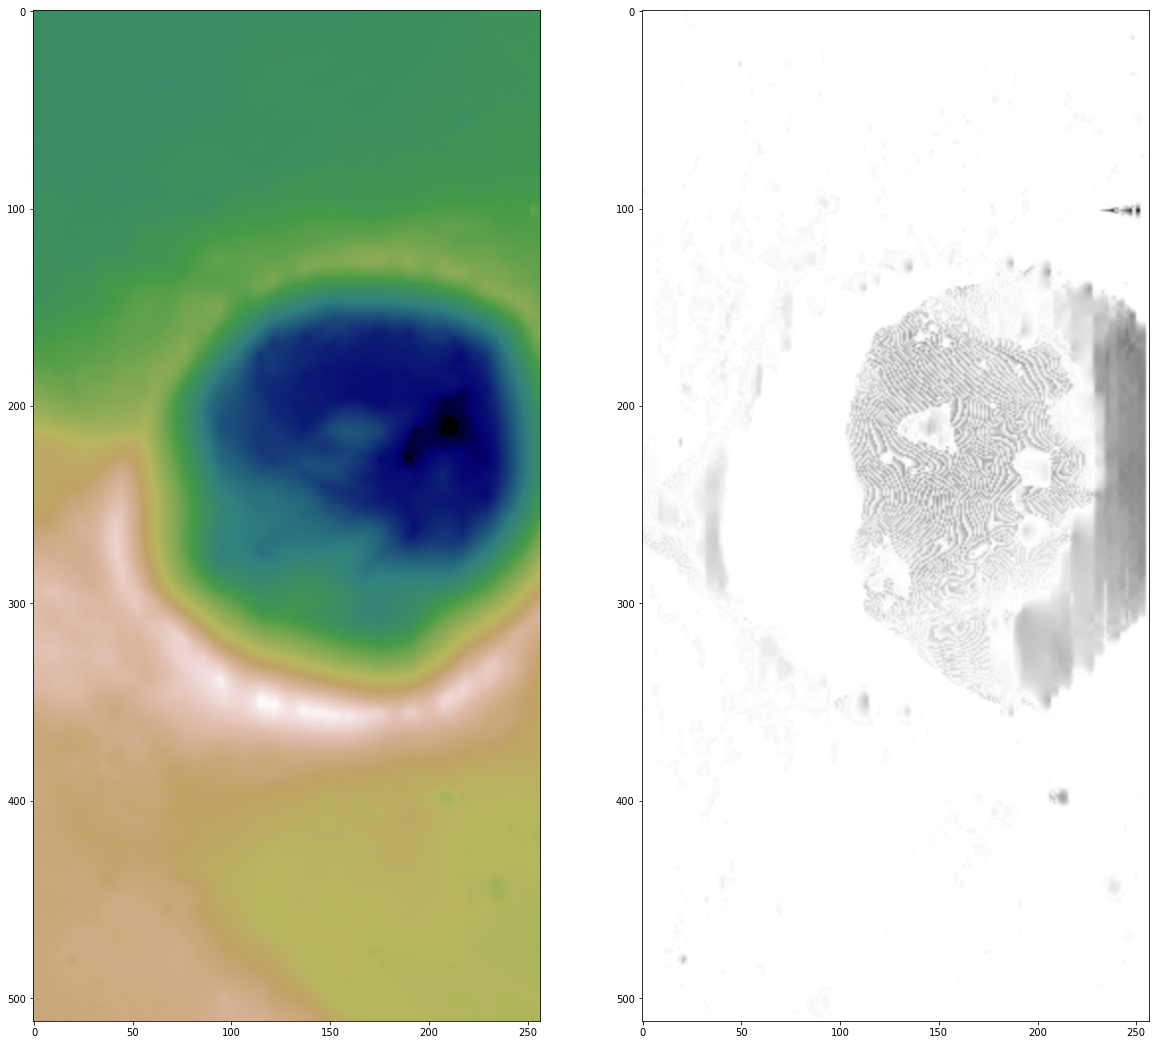

In [93]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(crop[:, :-distance], cmap='gist_earth')
plt.subplot(1, 2, 2)
plt.imshow(-1*shadow, interpolation='quadric', cmap='gray')
plt.show()

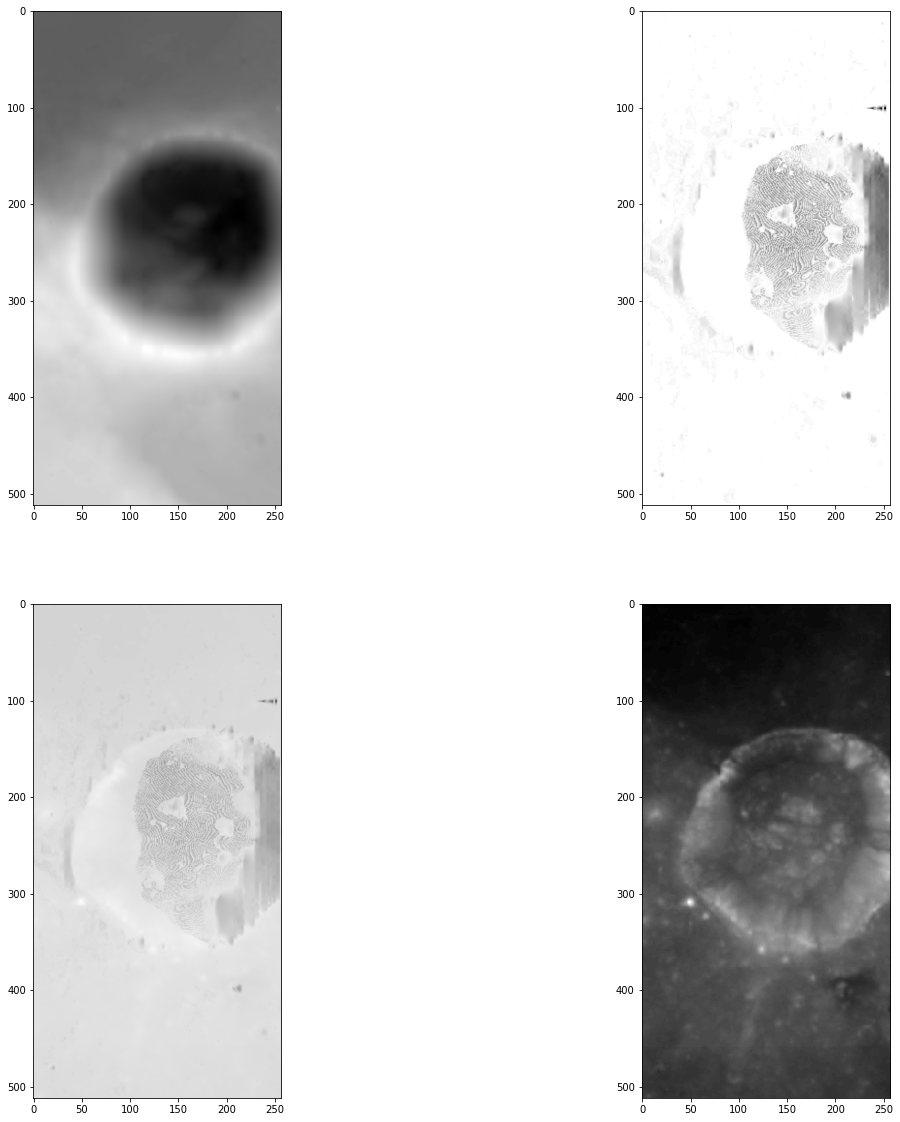

In [94]:
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.subplot(2, 2, 1)
plt.imshow(crop[:, :-distance],  cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(shadow, cmap='binary', interpolation='gaussian', vmin=0)
plt.subplot(2, 2, 3)
plt.imshow(shadow+(np.max(acrop)-acrop)/2, cmap='binary', interpolation='gaussian', vmin=0, vmax=200)
plt.subplot(2, 2, 4)
plt.imshow(acrop,  cmap='gray')
plt.show()
plt.imsave("topo.png", crop)
plt.imsave("shadow.png", shadow.T)

In [155]:
np.max(acrop)

55

TypeError: 'Dataset' object is not subscriptable

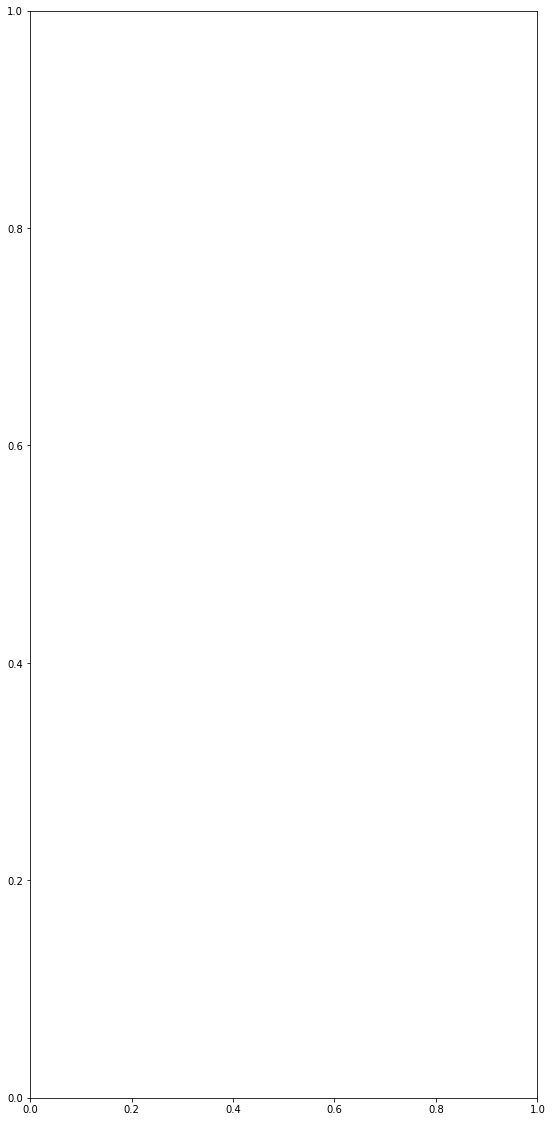

In [28]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(a[:, :-distance], cmap='gist_earth')
plt.subplot(1, 2, 2)
plt.imshow(-1*out.T, interpolation='quadric', cmap='gist_earth')
plt.show()

TypeError: 'Dataset' object is not subscriptable

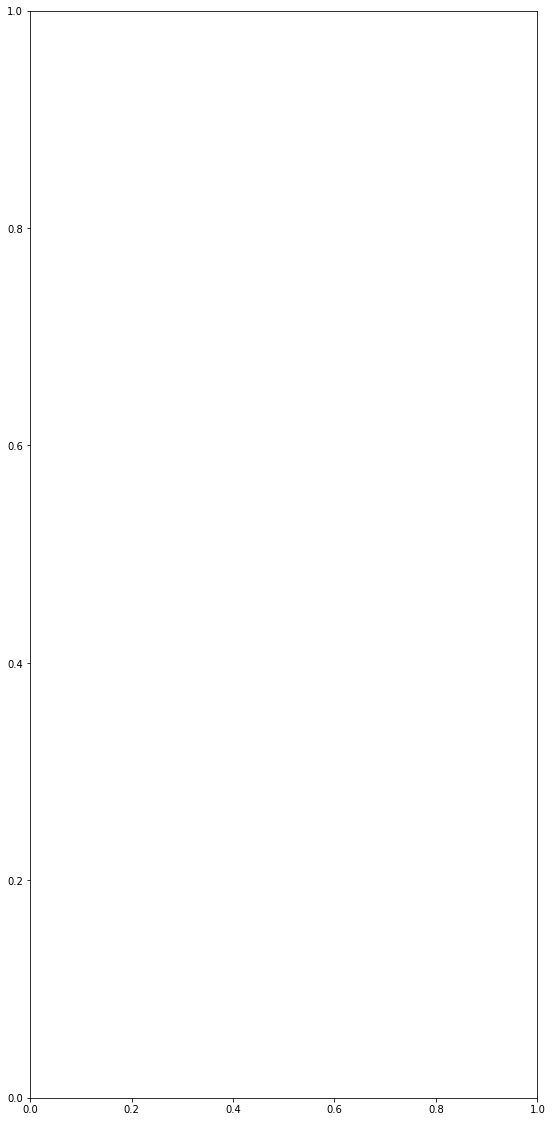

In [29]:
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.imshow(a[:, :-distance],  cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out.T, cmap='binary', interpolation='gaussian', vmin=0, vmax=2)
plt.show()
plt.imsave("topo.png", a)
plt.imsave("shadow.png", out.T)

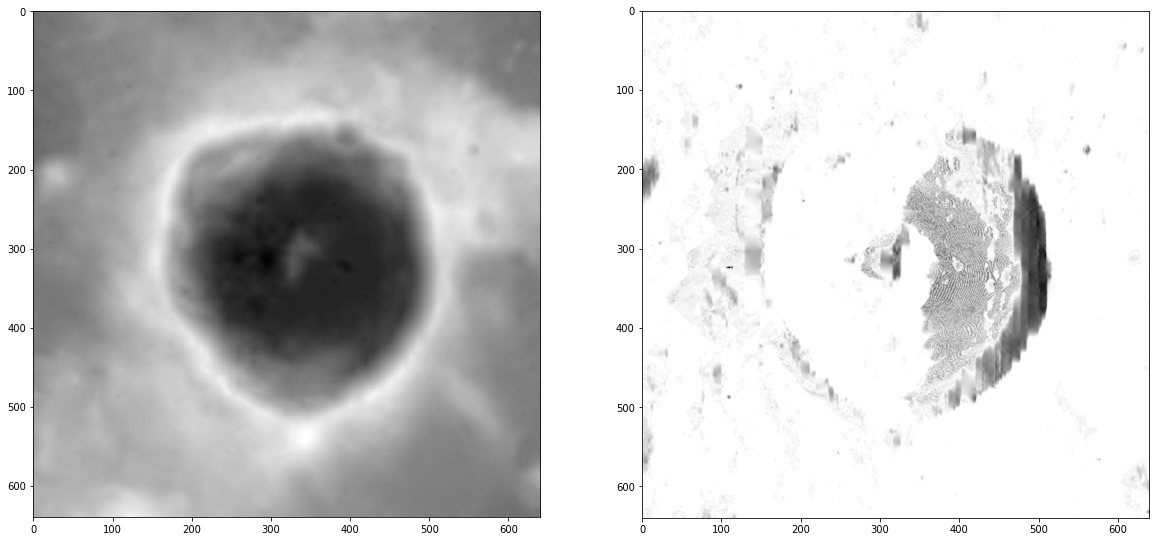

In [611]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(a[:, :-distance],  cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out.T, cmap='binary', interpolation='quadric', vmin=0, vmax=None)
plt.show()